# CatBoost Event Category Classification & SHAP Values

In this notebook, the CatBoost classifier is used to predict the event categories bases on the feature values. The SHAP values are then calculated to understand the importance of the features in the prediction. The SHAP values are then used to explain the predictions of the model.

# Requirements

Structure of Input Data:



Libraries:

# Import Libraries

In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# catboost
from catboost import CatBoostClassifier

# scikit-learn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder

# shap
import shap
shap.initjs() # is interpreted by the Jupyter notebook to perform load the necessary JavaScript for SHAP's interactive visualizations to work in notebook

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
%matplotlib inline

# Load Data

In [7]:
df_train = pd.read_csv("../data/ground_truth_features_grouped_train.csv")
df_test = pd.read_csv("../data/ground_truth_features_grouped_test.csv")

df_train.shape, df_test.shape

((131, 9), (57, 9))

# Inspect Data

In [8]:
# Show the head of the data
df_train.head()

,document,event_trigger,Measurability,Temporal Status,Event Factuality,Keyword is Nsubj,Keyword is Dobj,Keyword is Pobj,category
0,1.txt,75-83 [includes],1,ongoing,_,False,False,True,situation
1,10.txt,125-135 [delivering],2,ongoing,max,False,True,False,action
2,10.txt,27-36 [improving],1,ongoing,max,False,False,False,action
3,100.txt,111-118 [support],2,ongoing,low,False,True,False,action
4,100.txt,19-26 [focuses],1,ongoing,max,True,False,False,situation


## Select Relevant Columns

In [9]:
# Specify categorical columns
categorical_columns = ['Temporal Status', 'Event Factuality', 'Keyword is Nsubj', 'Keyword is Dobj', 'Keyword is Pobj']

In [10]:
df_train = df_train.dropna()
df_test = df_test.dropna()

# Prepare Data for Model Training

**Select X and y**

In [12]:
X_train = df_train[['Measurability', 'Temporal Status','Event Factuality', 'Keyword is Nsubj', 'Keyword is Dobj', 'Keyword is Pobj']]
X_test = df_test[['Measurability', 'Temporal Status','Event Factuality', 'Keyword is Nsubj', 'Keyword is Dobj', 'Keyword is Pobj']]
y_train = df_train['category']
y_test = df_test['category']

**Transform Target Variable**

In [13]:
# scikit needs 1 dim array for target variable
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [14]:
# Initialize the 'category' label encoder
le_category = LabelEncoder()

# Fit label encoder and return encoded labels
y = le_category.fit_transform(y_train)

# Create dictionary to map category to index
mapping_category_to_index = {category: index for index, category in enumerate(le_category.classes_)}

# Create a list of the category label names
category_names = list(le_category.classes_)

print(mapping_category_to_index, category_names)

{'action': 0, 'belief': 1, 'intention': 2, 'situation': 3} ['action', 'belief', 'intention', 'situation']


**Transform Feature Variables**

This enables us to see the SHAP values for each subclass of the categorical feature. E.g. temporal_status.past etc.

In [15]:
# Transform Numerical Measurability from String to Integer
X_train['Measurability'] = X_train['Measurability'].astype('int')
X_test['Measurability'] = X_test['Measurability'].astype('int')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Get Mapping Features to Indices**

In [16]:
mapping_feature_to_index = {feature: index for index, feature in enumerate(X_train.columns)}
mapping_index_to_feature = {index: feature for index, feature in enumerate(X_train.columns)}
mapping_feature_to_index

{'Measurability': 0,
 'Temporal Status': 1,
 'Event Factuality': 2,
 'Keyword is Nsubj': 3,
 'Keyword is Dobj': 4,
 'Keyword is Pobj': 5}

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((131, 6), (57, 6), (131,), (57,))

### Specify Categorical Columns for Training

In [19]:
# Define indices of categorical and numerical features
idx_categorical_features = [X_train.columns.get_loc(col) for col in X_train.columns if col in categorical_columns]
idx_numerical_features = [X_train.columns.get_loc(col) for col in X_train.columns if col not in categorical_columns]

print(f'\n{X_train.columns.to_list()} \nidx of categorical features: {idx_categorical_features}')


['Measurability', 'Temporal Status', 'Event Factuality', 'Keyword is Nsubj', 'Keyword is Dobj', 'Keyword is Pobj'] 
idx of categorical features: [1, 2, 3, 4, 5]


# Hyperparameter Tuning

Source: https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/

- Learning Rate: Imagine a choir where each singer adds their voice to create the perfect harmony. However, some singers have louder voices than others, so the choir director instructs them to adjust their volume to maintain balance. In CatBoost, the learning rate operates similarly—it scales the contribution of each decision tree to manage the overall balance and accuracy of the model. A smaller learning rate signifies that each tree offers a smaller “voice,” or a smaller update to the model, resulting in gradual learning. This can lead to higher accuracy but increases the risk of underfitting and longer training times.
A larger learning rate, on the other hand, means each tree has a more significant impact on the model, speeding up the learning process. However, a high learning rate can result in overfitting or model instability. A range of 0.001 to 0.1 is a good starting point.

- depth: You can think of the depth as the complexity or “height” of decision trees in your CatBoost model. A higher depth can capture more intricate patterns in your data, leading to better performanc But there’s a catch - the deeper the tree, the more time it takes to train, and the higher the risk of overfitting.

- subsample: Subsampling is a technique used to randomly choose a fraction of the dataset when constructing each tree. This promotes diversity among the trees and helps reduce overfitting. The subsample parameter ranges I recommend go from 0.05 to 1. Lower values increase diversity but may result in underfitting.

- min data in leaf: min_data_in_leaf specifies the minimum number of samples required to create a leaf, effectively controlling the split creation process. Think about it as: how many data points will the tree use to estimate a prediction? Higher values generate less complex trees, reducing overfitting risks, but might result in underfitting. Lower values lead to more complex trees that might overfit. I like to consider values between 1 and 100.

In [20]:
from sklearn.metrics import mean_squared_error, f1_score
import optuna

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True), # learning_rate is searched within a logarithmic scale from 1e-3 to 0.1
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        # -------------
        'leaf_estimation_method': 'Gradient',
        'bootstrap_type': 'Bernoulli',
        'objective': 'MultiClass',
        'random_state': 42,
        'verbose': 0,
        "eval_metric" : 'TotalF1',
        "early_stopping_rounds" : 100
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, cat_features=idx_categorical_features)
    predictions = model.predict(X_test)

    # Return the F1-score to maximize
    f1 = f1_score(y_test, predictions, average='macro')
    return f1

In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=60)

[I 2024-06-27 15:39:48,017] A new study created in memory with name: no-name-c158194e-de35-41b7-8d97-15f0043f22d5
[I 2024-06-27 15:39:50,228] Trial 0 finished with value: 0.3640692640692641 and parameters: {'learning_rate': 0.00498335433933691, 'depth': 5, 'subsample': 0.2340201813060433, 'colsample_bylevel': 0.41552055385057407, 'min_data_in_leaf': 77}. Best is trial 0 with value: 0.3640692640692641.
[I 2024-06-27 15:39:53,452] Trial 1 finished with value: 0.34663865546218486 and parameters: {'learning_rate': 0.001687085325487649, 'depth': 9, 'subsample': 0.5915381836592977, 'colsample_bylevel': 0.3813377629484344, 'min_data_in_leaf': 63}. Best is trial 0 with value: 0.3640692640692641.
[I 2024-06-27 15:39:55,105] Trial 2 finished with value: 0.3888888888888889 and parameters: {'learning_rate': 0.0036691035225124135, 'depth': 9, 'subsample': 0.9816121778317314, 'colsample_bylevel': 0.18478515665849227, 'min_data_in_leaf': 41}. Best is trial 2 with value: 0.3888888888888889.
[I 2024-06

In [22]:
print('Best hyperparameters:', study.best_params)
print('Best weighted f1:', study.best_value)

Best hyperparameters: {'learning_rate': 0.08231187256251175, 'depth': 3, 'subsample': 0.23629200741443823, 'colsample_bylevel': 0.5702985041398904, 'min_data_in_leaf': 12}
Best weighted f1: 0.4997031703928256


# CatBoost Model Training

**Create CatBoost Model**

Options: 
* https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
* https://catboost.ai/en/docs/references/training-parameters/ 

In [23]:
params = {
    'leaf_estimation_method': 'Gradient',
    'learning_rate': 0.05599447214373542,
    'depth': 5,
    'bootstrap_type': 'Bernoulli',
    'objective': 'MultiClass',
    'subsample': 0.14439138713112645,
    'colsample_bylevel': 0.7334294913535412,
    'min_data_in_leaf': 93,
    'random_state': 42,
    'verbose': 0,
    "eval_metric" : 'TotalF1',
    "early_stopping_rounds" : 100
    }

In [24]:
# Create the model
model = CatBoostClassifier(**params)

**Fit Model**

In [25]:
# Fit the model
model.fit(X_train, y_train, idx_categorical_features)

# Evaluate Model Performance

In [26]:
# Get predictions
y_pred = model.predict(X_test)

In [27]:
category_names_capitalized = [name.capitalize() for name in category_names]

In [28]:
# report = classification_report(y_test, y_pred, target_names=category_names)
report = classification_report(y_test, y_pred, target_names=category_names)
print(report)

              precision    recall  f1-score   support

      action       0.33      0.33      0.33        12
      belief       0.47      0.47      0.47        15
   intention       0.91      0.56      0.69        18
   situation       0.37      0.58      0.45        12

    accuracy                           0.49        57
   macro avg       0.52      0.48      0.49        57
weighted avg       0.56      0.49      0.51        57



In [29]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[ 4  2  1  5]
 [ 4  7  0  4]
 [ 3  2 10  3]
 [ 1  4  0  7]]


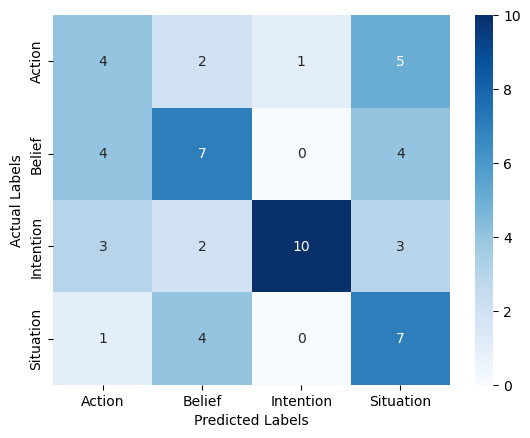

In [30]:
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert confusion matrix to DataFrame for better label handling
cm_df = pd.DataFrame(cm, index=category_names_capitalized, columns=category_names_capitalized)

# Plotting
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')

# Plotting
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# plt.savefig(f'plots/catboost_confusion_matrix.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Feature Importance

In [32]:
# https://catboost.ai/en/docs/concepts/fstr
model.feature_importances_

array([ 7.18638032, 33.39703584, 44.821183  ,  0.53228534,  6.60647959,
        7.4566359 ])

# SHAP

In [34]:
# combine X_train and X_test
X = pd.concat([X_train, X_test])

**Tree Explainer**

In [35]:
tree_explainer = shap.TreeExplainer(model)

shap_tree_values = tree_explainer.shap_values(X)

type(shap_tree_values), len(shap_tree_values)

(list, 4)

**Explainer**

In [36]:
explainer = shap.Explainer(model)

shap_values = explainer(X)

type(shap_values), shap_values.shape

(shap._explanation.Explanation, (188, 6, 4))

In [37]:
category_names_cap = [name.capitalize() for name in category_names]

## All Categories, All Features

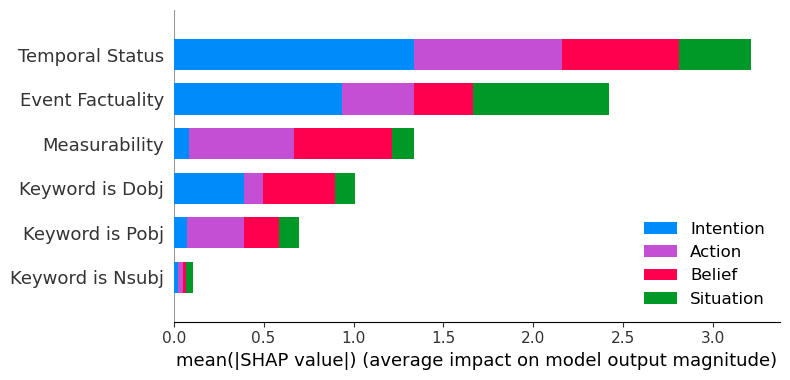

In [38]:
shap.summary_plot(shap_tree_values, X, plot_type="bar", class_names=category_names_cap) # Use shap_tree_values here
# shap.summary_plot(shap_tree_values, X_train, plot_type="bar", class_names=category_names) # Use shap_tree_values here

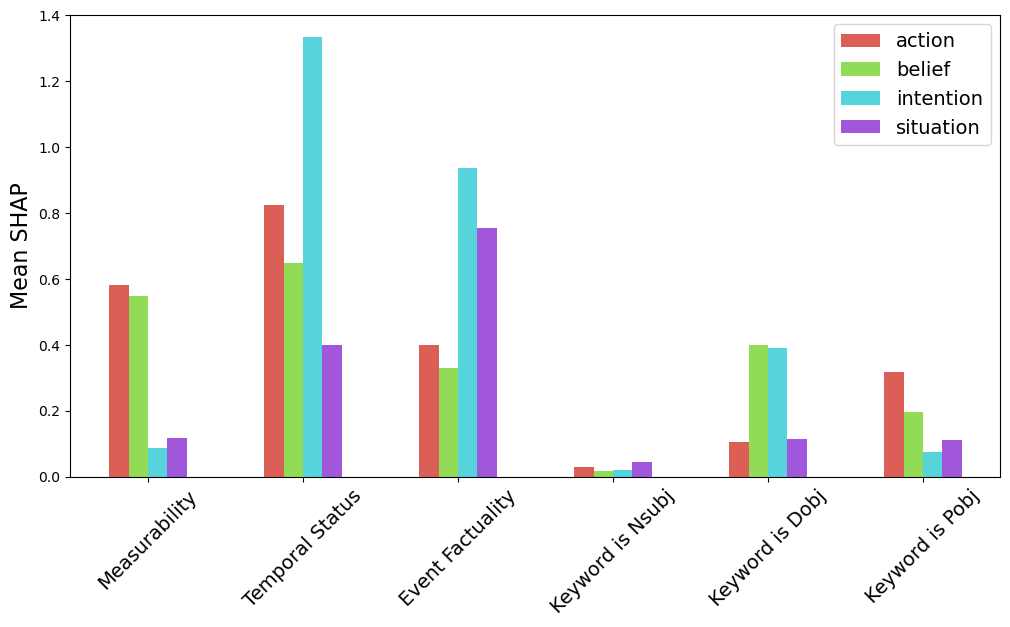

In [40]:
# calculate mean SHAP values for each class
mean_0 = np.mean(np.abs(shap_values.values[:, :, 0]), axis=0)
mean_1 = np.mean(np.abs(shap_values.values[:, :, 1]), axis=0)
mean_2 = np.mean(np.abs(shap_values.values[:, :, 2]), axis=0)
mean_3 = np.mean(np.abs(shap_values.values[:, :, 3]), axis=0)

name_0 = category_names[0]
name_1 = category_names[1]
name_2 = category_names[2]
name_3 = category_names[3]

df = pd.DataFrame({name_0: mean_0, name_1: mean_1, name_2: mean_2, name_3: mean_3})

hls_colors = sns.color_palette('hls', 4)  # 4 for the number of categories
# hls_colors = ['blue', 'purple', 'red', 'green'] # 4 for the number of categories

# plot mean SHAP values
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df.plot(kind='bar', ax=ax, color=hls_colors) 

ax.set_ylabel("Mean SHAP", size=16)
ax.set_xticklabels(X.columns, rotation=45, size=14)
ax.legend(fontsize=14)

# plt.savefig(f'plots/shap_all_vertical.eps', format='eps', bbox_inches='tight')
plt.show()

## Select Specific Category and Specific Feature for further Analysis

In [41]:
feature_name = 'Measurability'
idx_feature = mapping_feature_to_index[feature_name]

category_name = 'intention'
idx_category = mapping_category_to_index[category_name]

## Specific Category and All Features

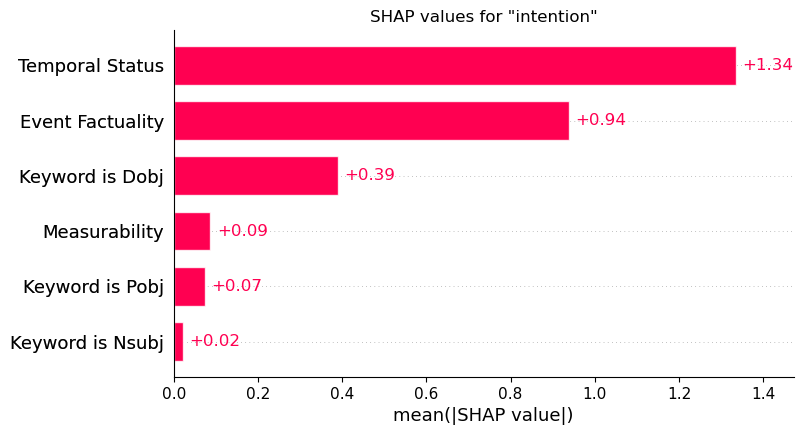

In [42]:
# Barplot for specific category
shap.plots.bar(shap_values[:,:,idx_category], show=False)

plt.title(f'SHAP values for "{category_name}"')

# plt.savefig(f'plots/shap_all_features_{category_name}.png', dpi=300, bbox_inches='tight')
plt.show()


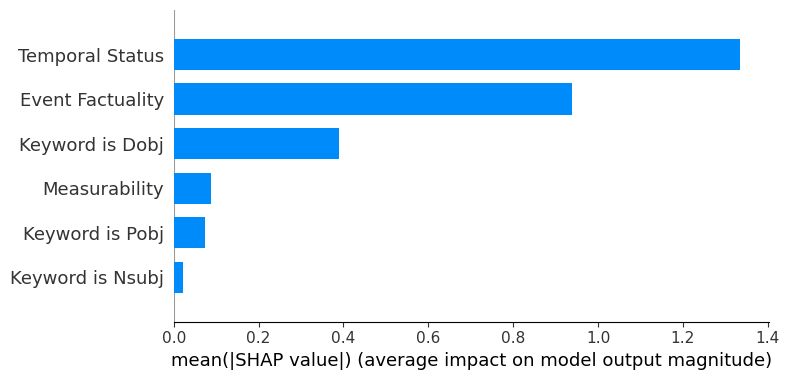

In [43]:
shap.summary_plot(shap_values = shap_values[:,:,idx_category], features = X, feature_names=X.columns.tolist(),  plot_type='bar', class_names=category_names) 

## Specific Category and Subclasses of Specific Feature

"One way is to use a beeswarm plot for an individual feature. You can see what we mean in Figure 6. Here we have grouped the SHAP values for the odor feature base on the odor category. For example, you can see that a foul smell leads to higher SHAP values. These mushrooms are more likely to be poisonous. In the previous article, we used boxplots to get similar results."

"We won’t discuss the code for this plot in detail. In a nutshell, we need to create a new SHAP values object, shap_values_odor. This is done by “post-processing” the SHAP values so they are in the form we want. We replace the original SHAP values with the SHAP values for odor (line 24). We also replace the feature names with the odor categories (line 43). If we create shap_values_odor correctly, we can use the beeswarm function to create the plot (line 46)."

https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/shap-for-categorical-features-with-catboost-8315e14dac1&sca_esv=ef71f34d62d470b0&strip=1&vwsrc=0

In [101]:

def boxplot_shap_values(idx_feature, idx_category, feature_name, category_name):

    #get shaply values and data
    feature_values = shap_values[:,idx_feature, idx_category].values
    feature_data = X[feature_name]

    #split odor shap values based on odor category
    feature_categories = feature_data.unique()

    # try to sort the feature categories
    feature_categories = sorted(feature_categories)

    if feature_name == 'Event Factuality':
        feature_categories = ['_', 'negative', 'low', 'medium', 'high', 'max']

    feature_groups = []
    for i in feature_categories:
        relevant_values = feature_values[feature_data == i]
        feature_groups.append(relevant_values)

    labels = feature_categories

    #plot boxplot
    plt.figure(figsize=(8, 5))

    plt.boxplot(feature_groups,labels=labels)

    feature_name_pretty = feature_name.replace('_', ' ').capitalize()
    category_name_pretty = category_name.capitalize()

    plt.ylabel('SHAP values',size=16)
    plt.xlabel(f'{feature_name_pretty}',size=16)
    plt.title(f'SHAP Values for {feature_name_pretty} and {category_name_pretty}',size=18)

    # plt.savefig(f'plots/shap_boxplot_{feature_name}_{category_name}.png', dpi=300, bbox_inches='tight')
    plt.show()


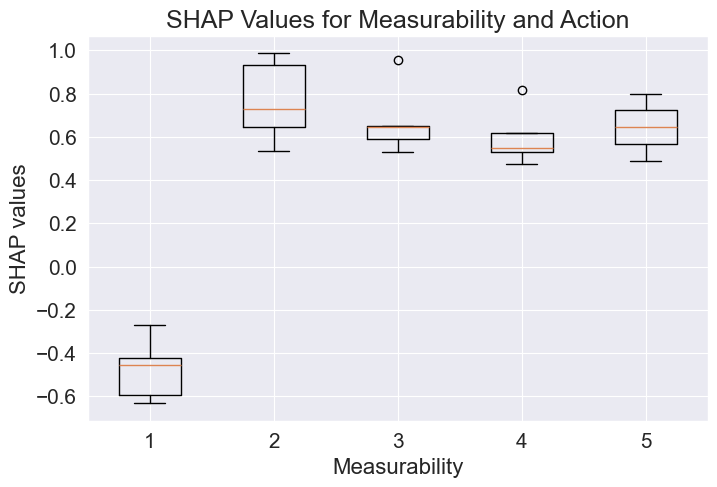

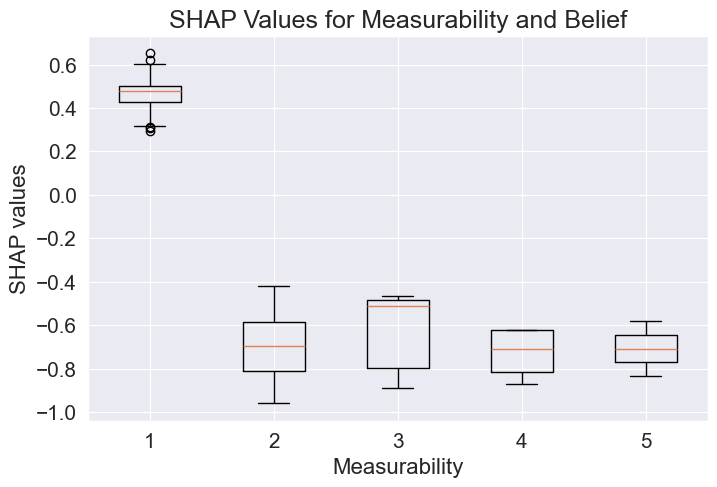

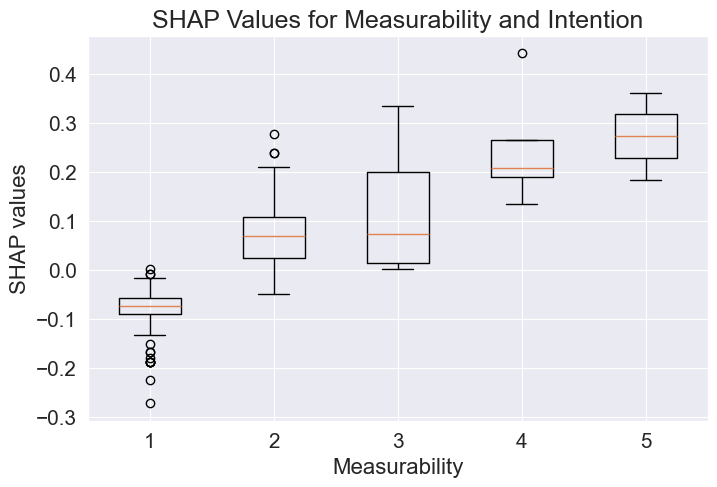

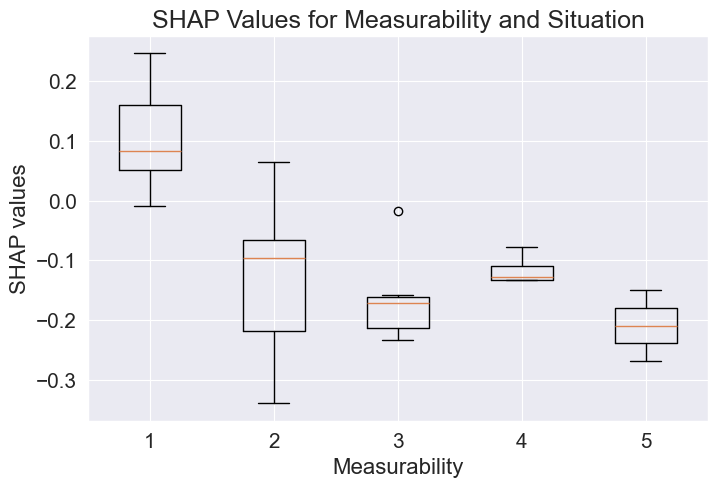

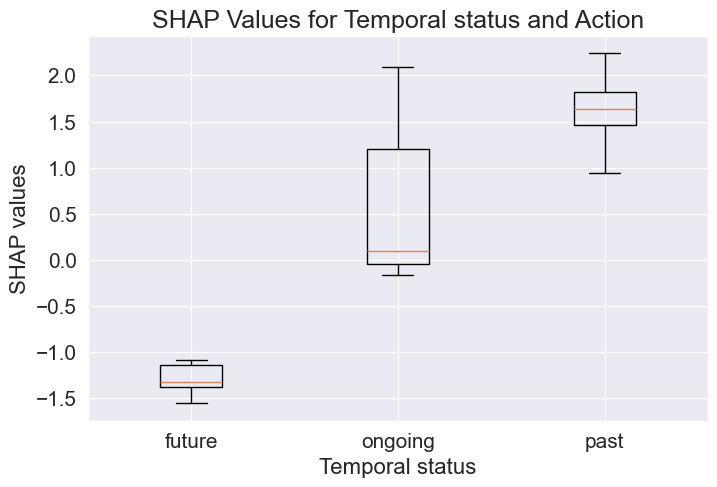

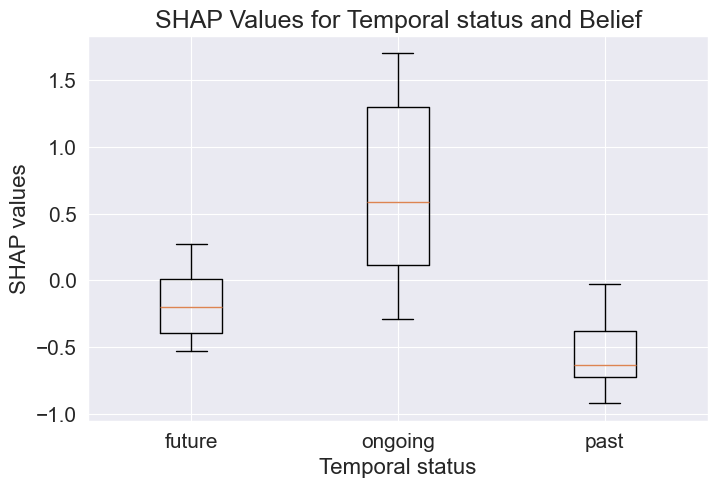

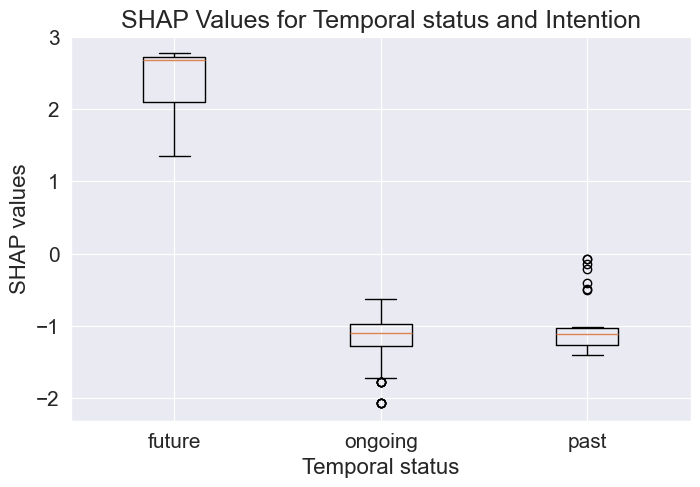

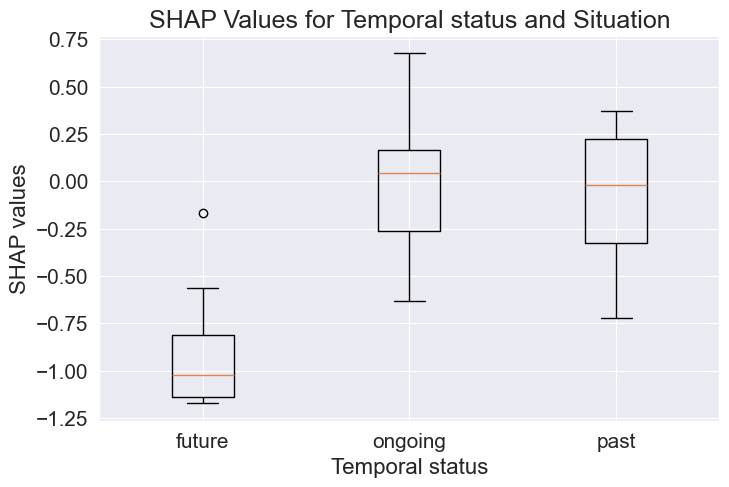

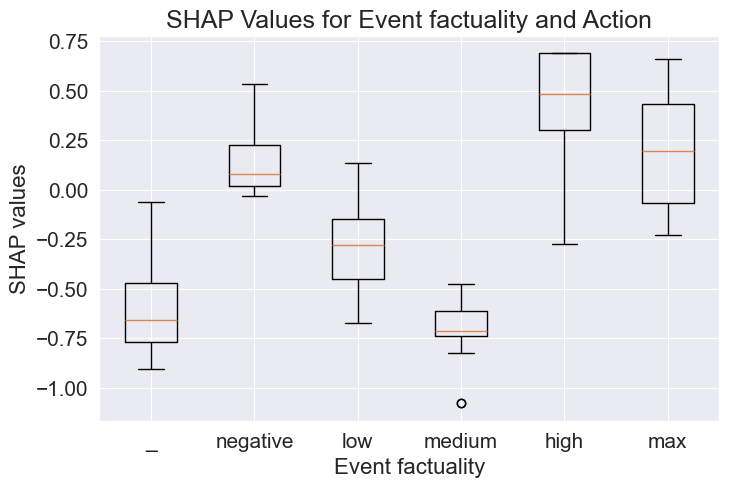

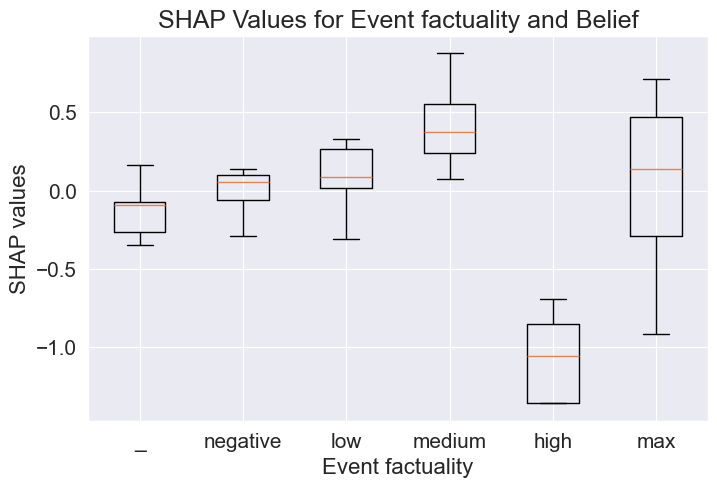

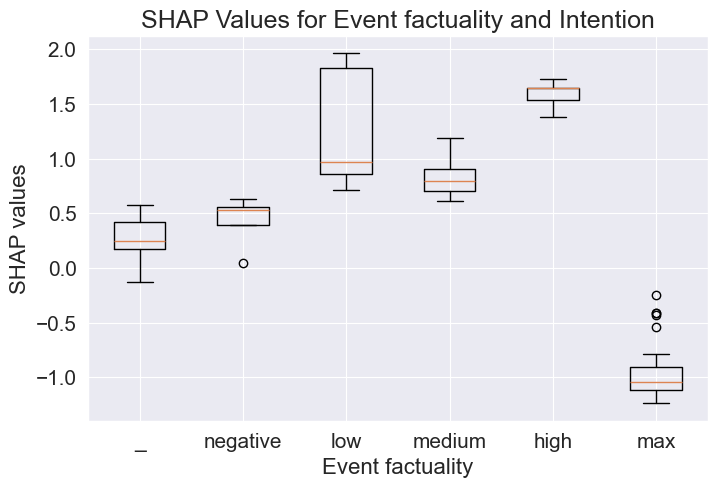

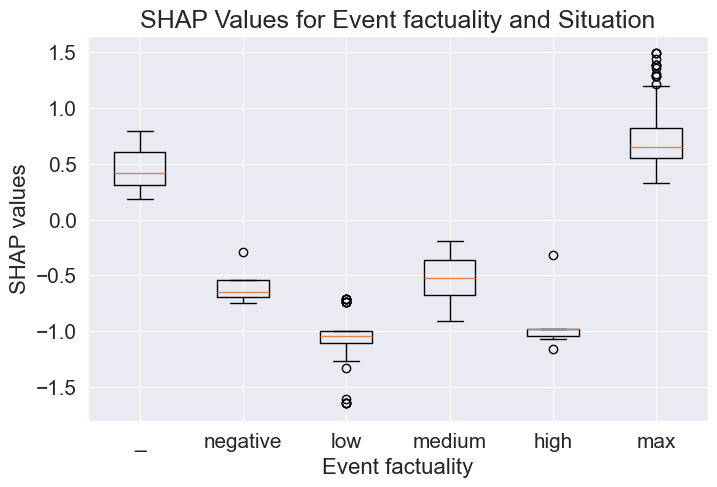

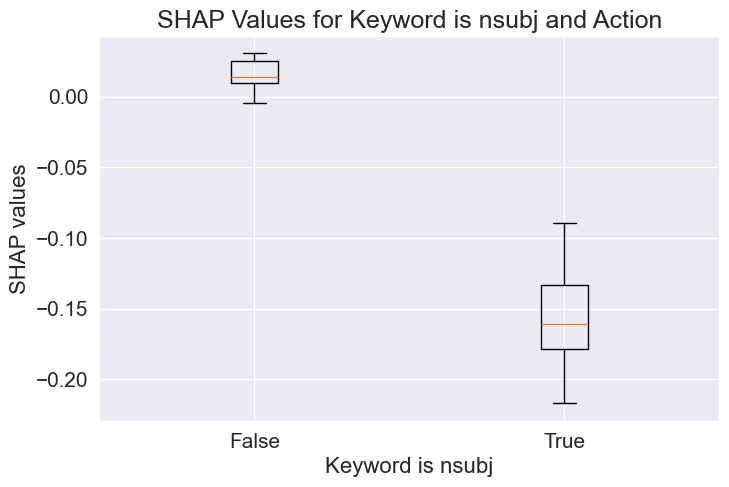

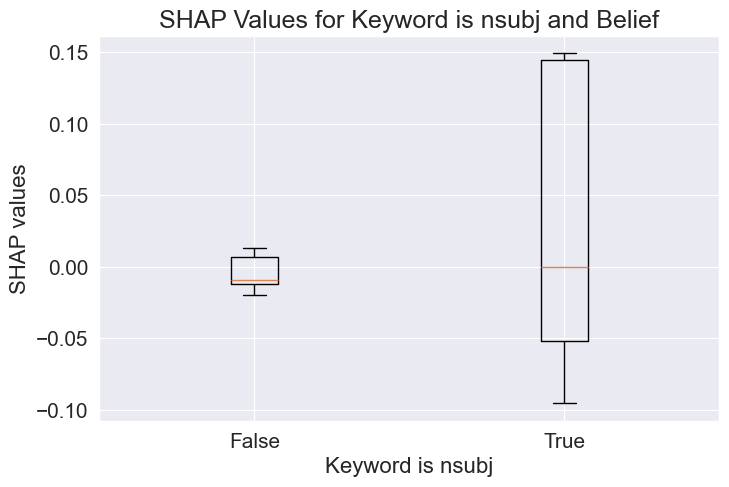

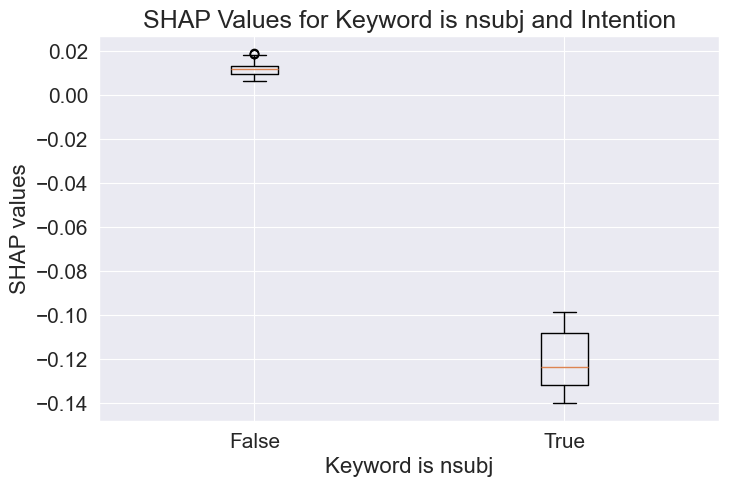

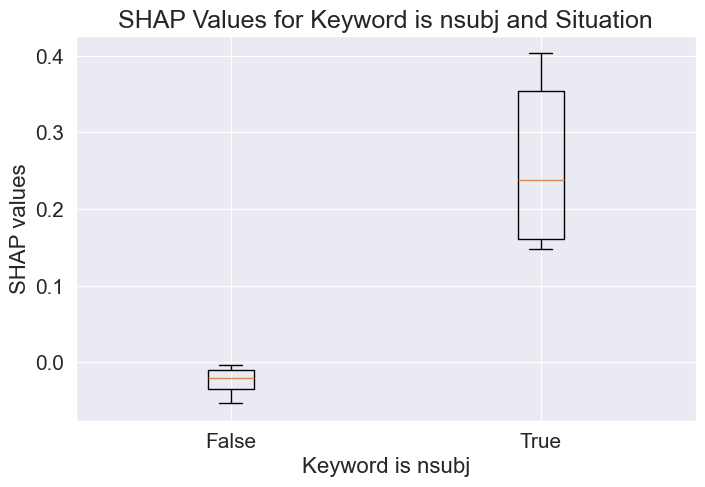

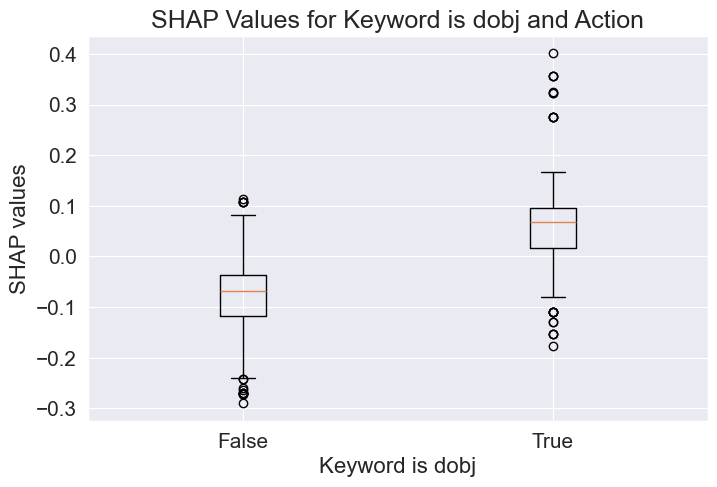

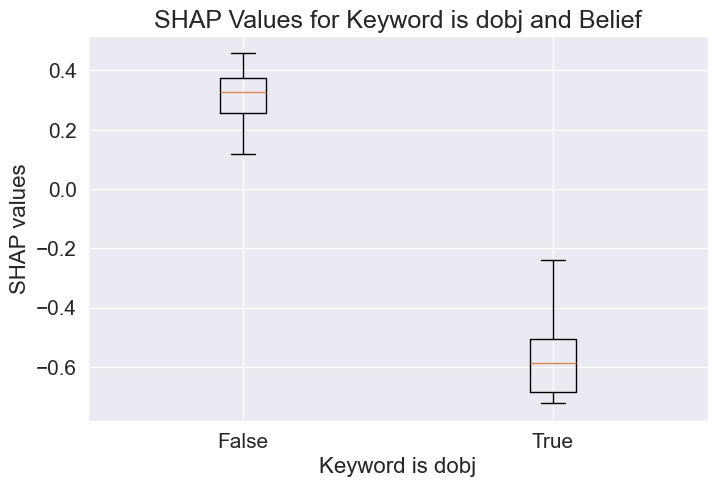

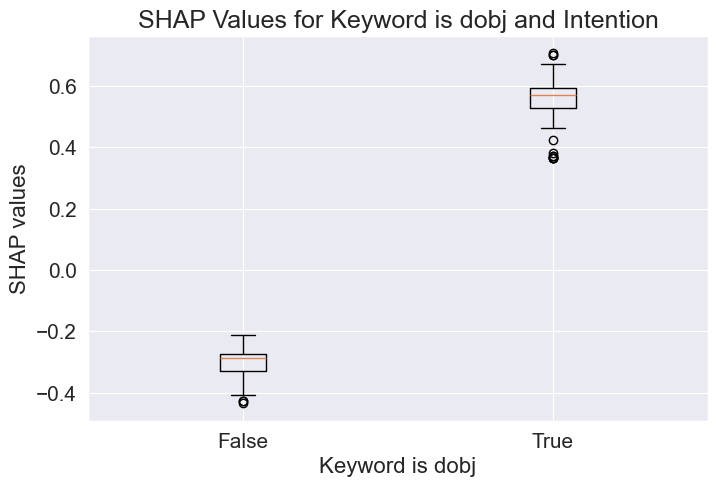

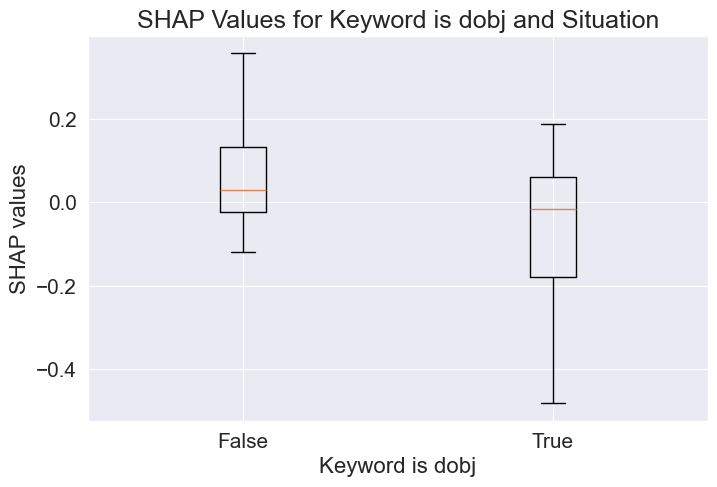

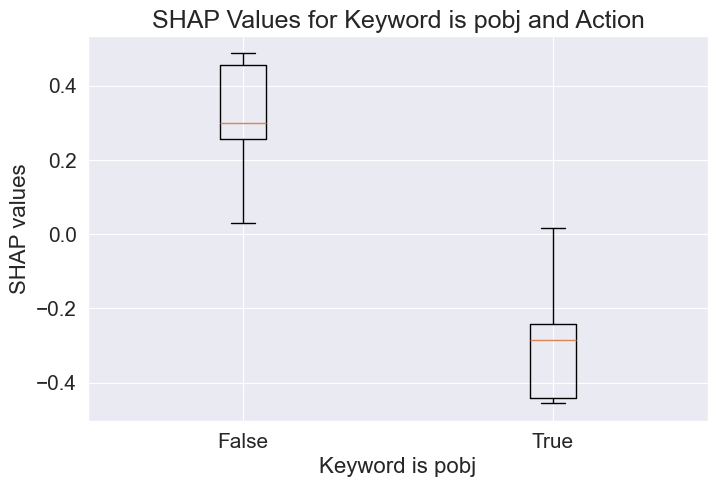

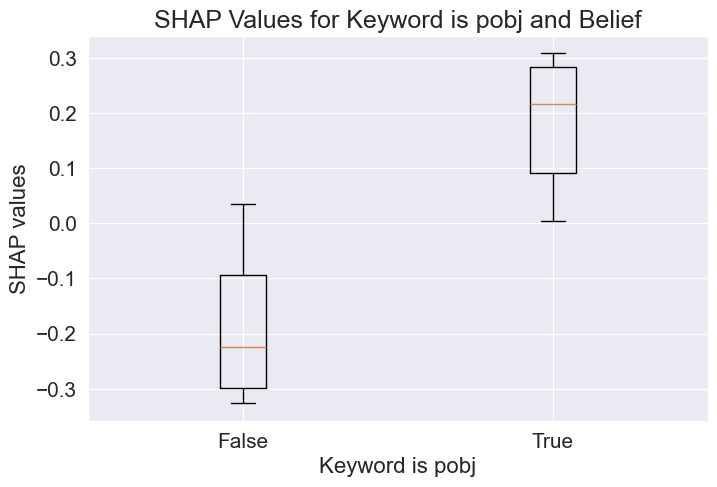

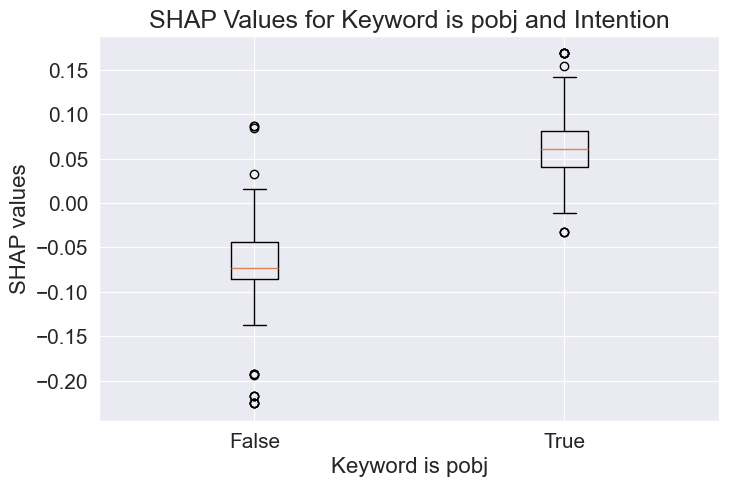

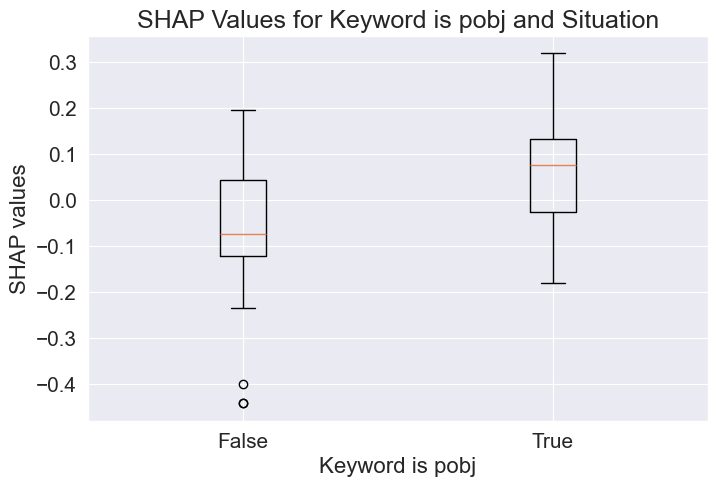

In [102]:
for feature_name in X.columns.to_list():
    idx_feature = mapping_feature_to_index[feature_name]

    for category_name in category_names:
        idx_category = mapping_category_to_index[category_name]

        boxplot_shap_values(idx_feature, idx_category, feature_name, category_name)


## Specific Cagegory, Specific Datapoint, and All Features

"We then visualise the SHAP values of the first prediction using a waterfall plot (line 6). You can see this plot in Figure 2. This tells us how each of the categorical feature values has contributed to the prediction. For example, we can see that this mushroom has an almond (a) odor. This has decreased the log odds by 0.85. In other words, it has decreased the likelihood that the mushroom is poisonous." 

https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/shap-for-categorical-features-with-catboost-8315e14dac1&sca_esv=ef71f34d62d470b0&strip=1&vwsrc=0

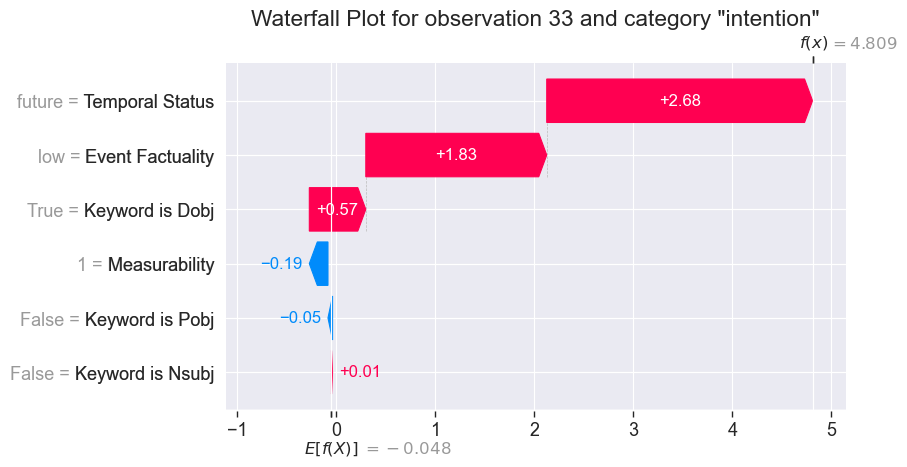

In [103]:
# Waterfall plot for specific observation, all features, and specific category

category_name = 'intention'
idx_category = mapping_category_to_index[category_name]

# Chose a specific observation
idx_observation = 33

shap.plots.waterfall(shap_values[idx_observation,:,idx_category], show=False)
plt.title(f'Waterfall Plot for observation {idx_observation} and category "{category_name}"')
# plt.savefig(f'plots/shap_waterfall_plot_id{idx_observation}_{category_name}.png', dpi=100, bbox_inches='tight', facecolor='white')
plt.show()